## I. Stock Return Forecasting with LSTM – Technical Assessment

This notebook is part of the Data Scientist Technical Test provided by Mandiri Sekuritas. The goal of this assessment is to build a stock return forecasting model using an LSTM (Long Short-Term Memory) neural network, following the methodology described in the referenced research paper.

### Objective

The objective of this project is to implement a deep learning-based time series forecasting model that predicts daily stock returns based on historical price data and technical indicators. The model is first developed and evaluated on NVIDIA (NVDA) stock data and later extended to four major Indonesian bank stocks to test its robustness.

### Key Tasks

- Replicate and adapt the methodology described in the original LSTM-based stock forecasting paper.
- Build a complete modeling pipeline including:
  - Data preprocessing
  - Feature engineering with technical indicators
  - Sequence generation for LSTM
  - Model training and evaluation
- Evaluate the model performance using both error-based metrics and directional accuracy.
- Apply the same pipeline to Indonesian bank stocks for cross-comparison.

### Stocks Analyzed

- Primary model development:
  - NVIDIA (NVDA)

- Extended evaluation:
  - BBCA (Bank Central Asia)
  - BBRI (Bank Rakyat Indonesia)
  - BBNI (Bank Negara Indonesia)
  - BMRI (Bank Mandiri)

### Target Variable

The model aims to predict the Daily Return (DR), computed as:


Daily Return (DR) = 100 * (Close - Open) / Open


### Technical Features

- Time windowing for sequence generation
- Feature scaling using StandardScaler
- Technical indicators calculated using the **ta** library:
  - Awesome Oscillator (AO)
  - Relative Strength Index (RSI)
  - Average True Range (ATR)
  - Average Directional Index (ADX)
  - Aroon Up and Down
- Evaluation metrics:
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Error (MAE)
  - Mean Absolute Percentage Error (MAPE)
  - Directional Accuracy (percentage of correct up/down predictions)


## II. Data Understanding & Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import yfinance as yf
import ta  # technical analysis

In [3]:
df = yf.download('NVDA', start='2020-01-01', end='2025-07-31')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


### Target Variable

In [4]:
# Calculate Target – Daily Return (DR)
df['DR'] = 100 * (df['Close'] - df['Open']) / df['Open']

### Exploratory Data Analysis (EDA)

In [5]:
# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)

# Filter the last 3 months of data
last_3_months = df.last('3M')

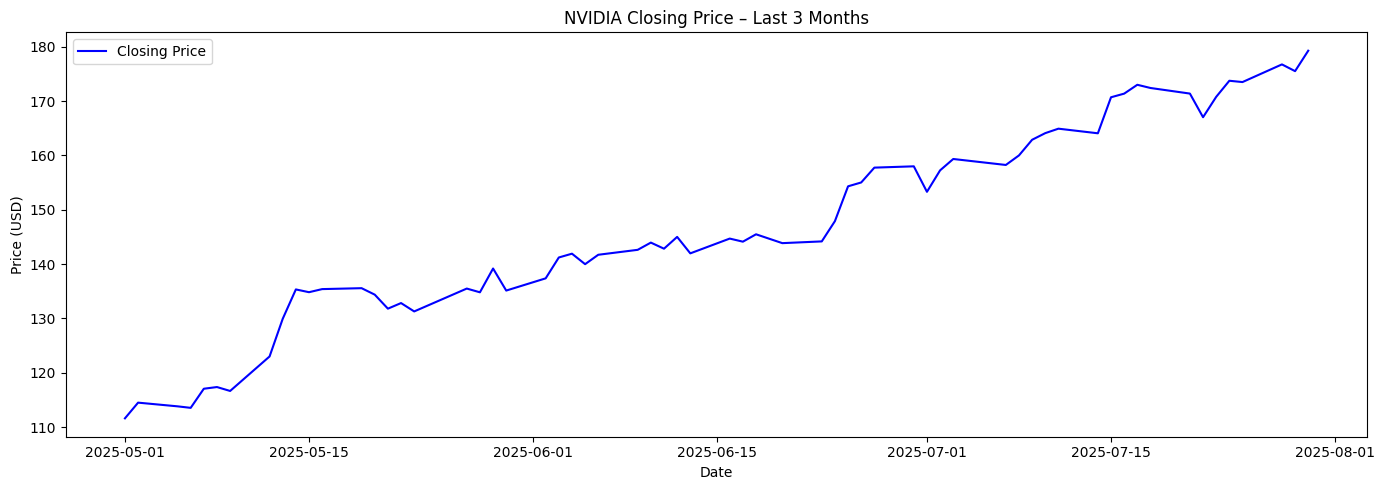

In [6]:
# Line Plot – Closing Price (Last 3 Months)
plt.figure(figsize=(14, 5))
plt.plot(last_3_months['Close'], label='Closing Price', color='blue')
plt.title('NVIDIA Closing Price – Last 3 Months')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

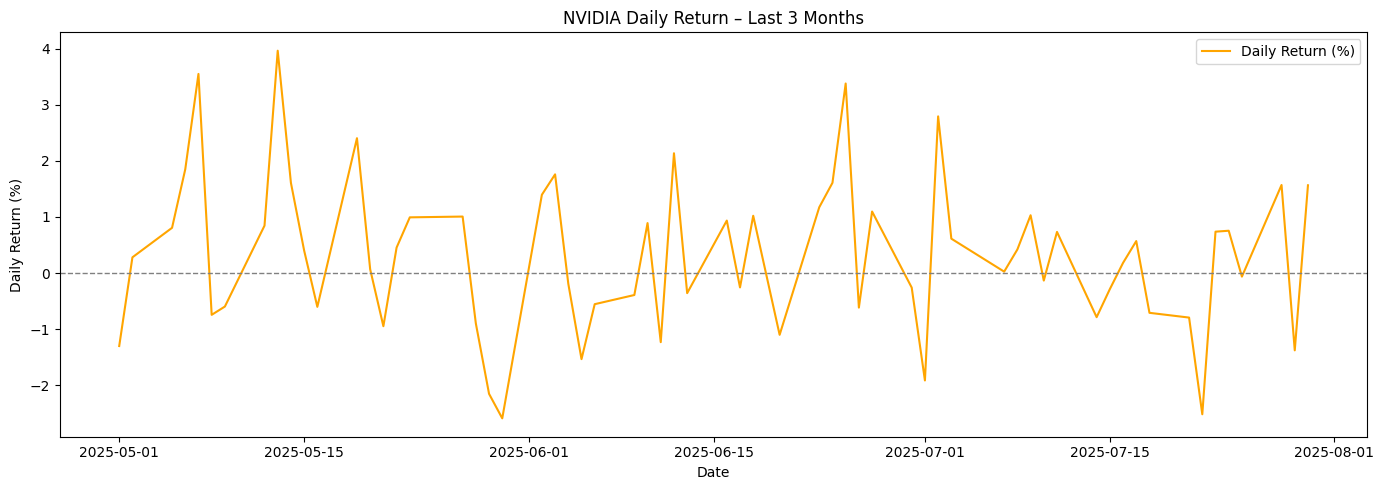

In [7]:
# Line Plot – Daily Return (Last 3 Months)
plt.figure(figsize=(14, 5))
plt.plot(last_3_months['DR'], label='Daily Return (%)', color='orange')
plt.title('NVIDIA Daily Return – Last 3 Months')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

**Stock Price and Daily Return Summary (Last Three Months)**

NVIDIA's stock price has risen sharply during the last three months, from roughly 110 to nearly 180 dolar by the end of July 2025. This means that the market is now experiencing considerable positive momentum.

However, the daily return (DR) plot shows significant volatility, with returns moving both positively and adversely. These short-term movements highlight the presence of noise and market reactions, which must be properly modeled.

### Technical indicators 
- Awesome Oscillator (AO)
- Relative Strength Index (RSI)
- Average True Range (ATR)
- Average Directional Index (ADX)
- Aroon Up and Down

In [8]:
from ta.momentum import AwesomeOscillatorIndicator, RSIIndicator
from ta.volatility import AverageTrueRange
from ta.trend import ADXIndicator, AroonIndicator

In [9]:
# AO
ao_indicator = AwesomeOscillatorIndicator(
    high=df['High'].squeeze(),
    low=df['Low'].squeeze()
)
ao_values = ao_indicator.awesome_oscillator()
df['AO'] = ao_values

In [10]:
# RSI
close_series = df['Close'].squeeze()  
rsi_indicator = RSIIndicator(close=close_series)
df['RSI'] = rsi_indicator.rsi()

In [11]:
# ATR
atr_indicator = AverageTrueRange(
    high=df['High'].squeeze(),
    low=df['Low'].squeeze(),
    close=df['Close'].squeeze(),
)

df['ATR'] = atr_indicator.average_true_range()

In [12]:
# ADX
adx_indicator = ADXIndicator(
    high=df['High'].squeeze(),
    low=df['Low'].squeeze(),
    close=df['Close'].squeeze()
)

df['ADX'] = adx_indicator.adx()

In [13]:
# Aroon Up & Down
aroon_indicator = AroonIndicator(close=df['Close'].squeeze())

df['Aroon_Up'] = aroon_indicator.aroon_up()
df['Aroon_Down'] = aroon_indicator.aroon_down()

In [14]:
df.head()

Price,Open,High,Low,Close,Volume,DR,AO,RSI,ATR,ADX,Aroon_Up,Aroon_Down
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,,,
Date,,,,,,,,,,,,
2020-01-02,5.942872,5.971746,5.892343,5.971746,237536000,0.485861,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-03,5.852019,5.919973,5.827127,5.876163,205384000,0.412591,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-06,5.782819,5.906033,5.756683,5.900805,262636000,2.040285,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-07,5.929181,6.018044,5.884127,5.972244,314856000,0.726282,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-08,5.968012,6.024765,5.927937,5.983445,277108000,0.258593,NaN,NaN,0.0,0.0,NaN,NaN


### Drop Multiindex & Null Values

In [15]:
# Drop multi-indexed columns (if any)
df.columns.name = None
df.columns = df.columns.get_level_values(0)

In [16]:
# Drop rows with NaN
df = df.dropna().copy()

In [17]:
# Check Dataframe
df.head()

Price,Open,High,Low,Close,Volume,DR,AO,RSI,ATR,ADX,Aroon_Up,Aroon_Down
Date,,,,,,,,,,,,
2020-02-20,7.785349,7.873714,7.376629,7.684041,810052000,-1.301274,0.983475,78.118049,0.241738,33.948094,96.0,48.0
2020-02-21,7.571781,7.596921,7.234997,7.319877,768180000,-3.326871,1.072428,65.772823,0.256546,35.057851,92.0,44.0
2020-02-24,6.725464,7.016198,6.670951,6.802379,856916000,1.143640,0.966485,52.963613,0.284573,33.568560,88.0,40.0
2020-02-25,6.877550,6.939531,6.421039,6.522845,1055496000,-5.157435,0.828458,47.574018,0.301282,31.360027,84.0,36.0
2020-02-26,6.523095,6.856394,6.521602,6.662239,747732000,2.133099,0.608991,50.290529,0.303675,29.309247,80.0,32.0


### Add Seasonal Features

In [18]:
# Add Seasonal Features
df['Day'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

# One-hot encoding
df = pd.get_dummies(df, columns=['Day', 'Month', 'Quarter'])

In [19]:
df.head()

,Open,High,Low,Close,Volume,DR,AO,RSI,ATR,ADX,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Quarter_1,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-20,7.785349,7.873714,7.376629,7.684041,810052000,-1.301274,0.983475,78.118049,0.241738,33.948094,...,False,False,False,False,False,False,True,False,False,False
2020-02-21,7.571781,7.596921,7.234997,7.319877,768180000,-3.326871,1.072428,65.772823,0.256546,35.057851,...,False,False,False,False,False,False,True,False,False,False
2020-02-24,6.725464,7.016198,6.670951,6.802379,856916000,1.143640,0.966485,52.963613,0.284573,33.568560,...,False,False,False,False,False,False,True,False,False,False
2020-02-25,6.877550,6.939531,6.421039,6.522845,1055496000,-5.157435,0.828458,47.574018,0.301282,31.360027,...,False,False,False,False,False,False,True,False,False,False
2020-02-26,6.523095,6.856394,6.521602,6.662239,747732000,2.133099,0.608991,50.290529,0.303675,29.309247,...,False,False,False,False,False,False,True,False,False,False


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1368 entries, 2020-02-20 to 2025-07-30
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1368 non-null   float64
 1   High        1368 non-null   float64
 2   Low         1368 non-null   float64
 3   Close       1368 non-null   float64
 4   Volume      1368 non-null   int64  
 5   DR          1368 non-null   float64
 6   AO          1368 non-null   float64
 7   RSI         1368 non-null   float64
 8   ATR         1368 non-null   float64
 9   ADX         1368 non-null   float64
 10  Aroon_Up    1368 non-null   float64
 11  Aroon_Down  1368 non-null   float64
 12  Day_0       1368 non-null   bool   
 13  Day_1       1368 non-null   bool   
 14  Day_2       1368 non-null   bool   
 15  Day_3       1368 non-null   bool   
 16  Day_4       1368 non-null   bool   
 17  Month_1     1368 non-null   bool   
 18  Month_2     1368 non-null   bool   
 19  Month_3  

### Define X and y

In [21]:
# Prepare X and y
X = df.drop(columns=['DR'])
y = df['DR']

In [22]:
### Data Splitting

In [23]:
from sklearn.model_selection import TimeSeriesSplit

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)
splits = list(tscv.split(X))

# Ambil fold terakhir
train_idx, test_idx = splits[-1]

# Split data
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

### Feature Scaling

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Create Sequences (3 consecutive days)

In [26]:
# Create Sequences
def create_sequences(X, y, window=3):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])    # Ambil sequence 3 hari
        ys.append(y[i+window])      # Target: DR hari ke-4
    return np.array(Xs), np.array(ys)

# Sequence for LSTM
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, window=3)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, window=3)

## III. Modeling

In this section, we build and train an LSTM (Long Short-Term Memory) model to predict the **daily return (DR)** of NVIDIA stock using price-based features and technical indicators.

The modeling approach strictly follows the methodology and LSTM architecture described in the research paper:

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_absolute_percentage_error

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### Model Architecture

In [28]:
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

In [29]:
model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [32]:
# Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.9989 - val_loss: 5.6196
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1762 - val_loss: 5.6814
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3771 - val_loss: 5.7526
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8783 - val_loss: 5.8625
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7931 - val_loss: 5.9026
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.3626 - val_loss: 6.0340
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8251 - val_loss: 6.4065
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8948 - val_loss: 6.4012
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8919 - val_loss: 6.5925
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5440 - val_loss: 7.5290
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0959 - val_loss: 6.6969
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7683 - val_l

In [33]:
# Prediction on test data
y_pred = model.predict(X_test_seq).reshape(-1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


### Evaluation Metrics

In [35]:
# Calculate evaluation metrics
rmse = mean_squared_error(y_test_seq, y_pred, squared=False)
mae = mean_absolute_error(y_test_seq, y_pred)

# Avoid division by zero in MAPE
mask = y_test_seq != 0
mape = mean_absolute_percentage_error(y_test_seq[mask], y_pred[mask])

# Calculate Directional Accuracy (correct up/down direction)
directional_acc = np.mean(np.sign(y_test_seq) == np.sign(y_pred)) * 100

# Print evaluation results
print(f"RMSE: {rmse: .4f}")
print(f"MAE: {mae: .4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Directional Accuracy: {directional_acc:.2f}%")

RMSE:  4.1371
MAE:  3.4451
MAPE: 7.11%
Directional Accuracy: 45.92%


# Model Evaluation Summary – NVIDIA (NVDA)

The LSTM model achieved the following performance on the test set:

- RMSE: 4.1371
- MAE: 3.4451
- MAPE: 7.11%
- Directional Accuracy: 45.92%

While the error metrics show a decent level of predictive accuracy in terms of size, the directional accuracy is still less than 50%, indicating that the model struggles to consistently anticipate the correct direction of price change. Additional tuning or feature upgrades may be required for directional improvement.

### Visualization

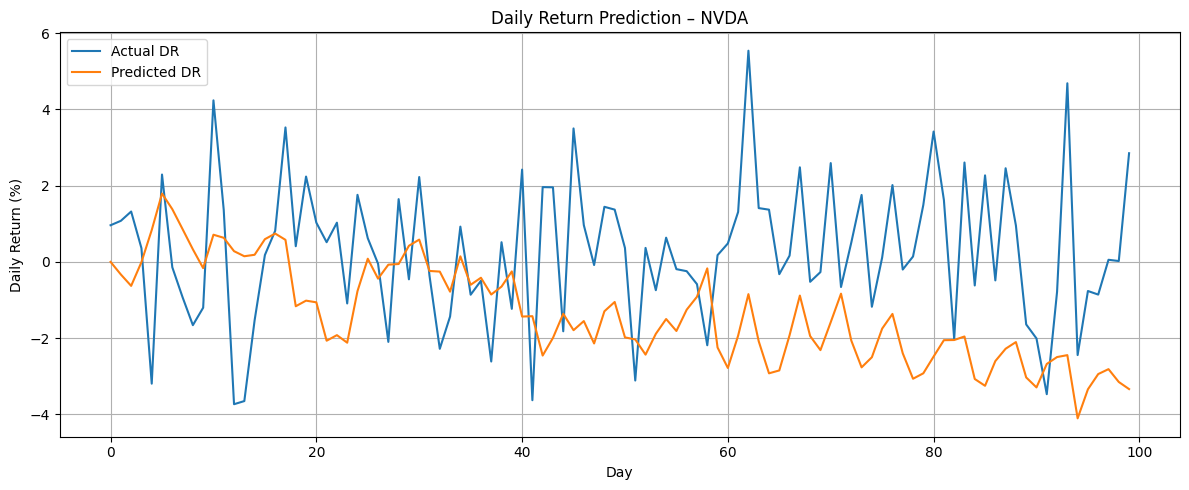

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_seq[:100], label='Actual DR')
plt.plot(y_pred[:100], label='Predicted DR')
plt.title('Daily Return Prediction – NVDA')
plt.xlabel('Day')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Daily Return Prediction: NVIDIA (NVDA)**
The line plot shows actual and expected daily returns over the last 100 trading days.
While the model covers the broad range of return changes, it undervalues high volatility and struggles to match rapid spikes and decreases. The anticipated returns are much smoother, showing a reduced response to high-frequency market movements.

### Modeling for big 4 bank in Indonesia
This modeling process will also be replicated for Indonesia’s Big 4 banks (BBCA, BBRI, BBNI, BMRI) for comparative analysis across markets.

[*********************100%***********************]  1 of 1 completed


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.6226 - val_loss: 5.5943
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5962 - val_loss: 5.6696
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4642 - val_loss: 5.8887
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0721 - val_loss: 5.8202
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1015 - val_loss: 5.9250
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4796 - val_loss: 5.9960
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5522 - val_loss: 6.4728
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9448 - val_loss: 6.4011
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.2742 - val_loss: 6.9086
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4263 - val_loss: 7.1175
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4081 - val_loss: 7.2061
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1821 

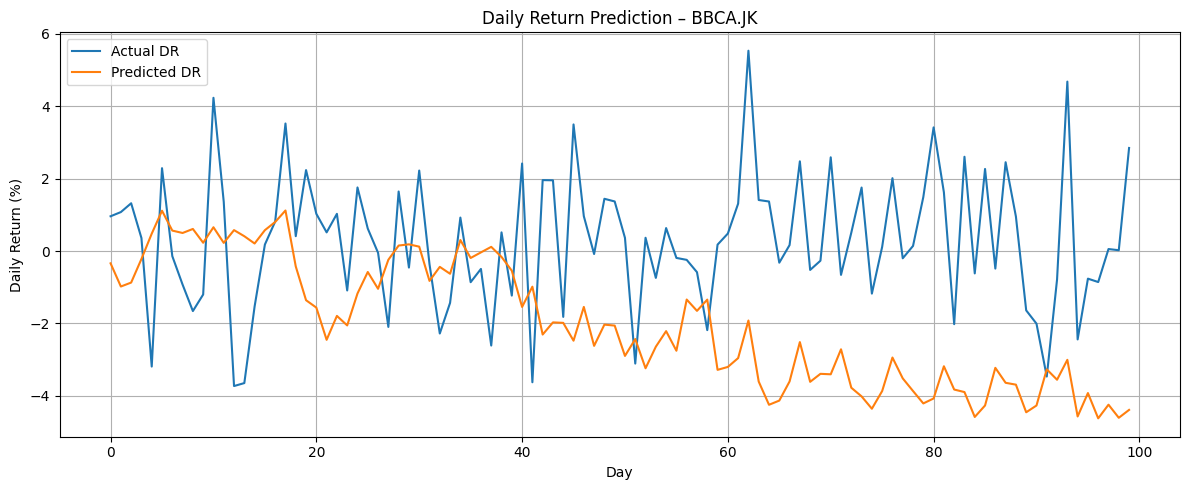

[*********************100%***********************]  1 of 1 completed


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.7013 - val_loss: 5.7152
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1690 - val_loss: 5.8132
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1930 - val_loss: 6.0231
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3838 - val_loss: 5.9788
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.0982 - val_loss: 6.3097
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.6308 - val_loss: 6.3195
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4443 - val_loss: 6.5817
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4414 - val_loss: 7.1760
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0059 - val_loss: 7.7986
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6335 - val_loss: 7.5684
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4790 - val_loss: 8.0354
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.027

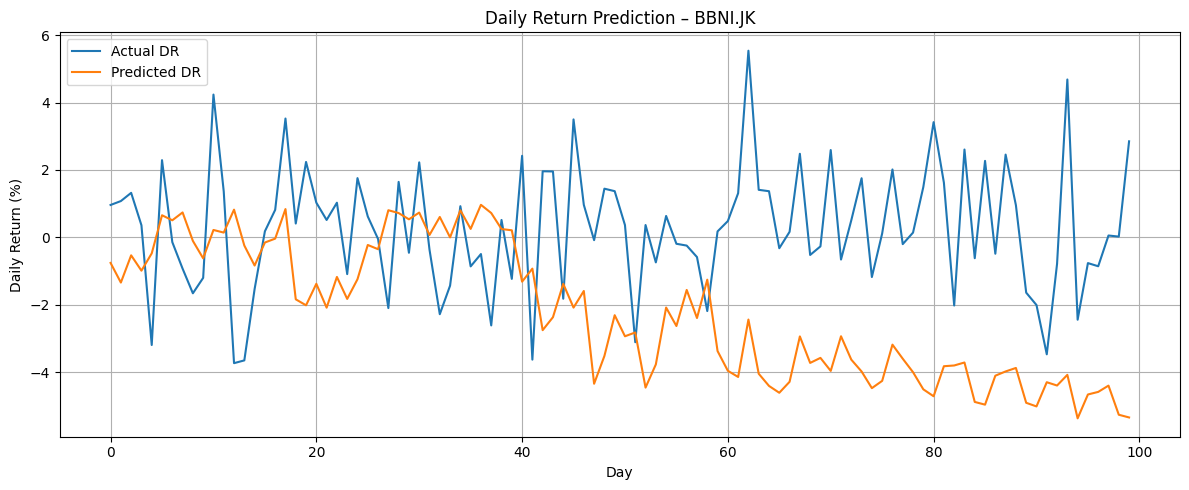

[*********************100%***********************]  1 of 1 completed


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.8186 - val_loss: 5.5550
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6864 - val_loss: 5.7508
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4429 - val_loss: 5.8501
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9279 - val_loss: 5.9037
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7348 - val_loss: 6.2053
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1506 - val_loss: 6.3436
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0278 - val_loss: 6.6997
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0197 - val_loss: 6.9796
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3193 - val_loss: 7.0428
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1735 - val_loss: 7.4205
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7960 - val_loss: 7.3977
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2970

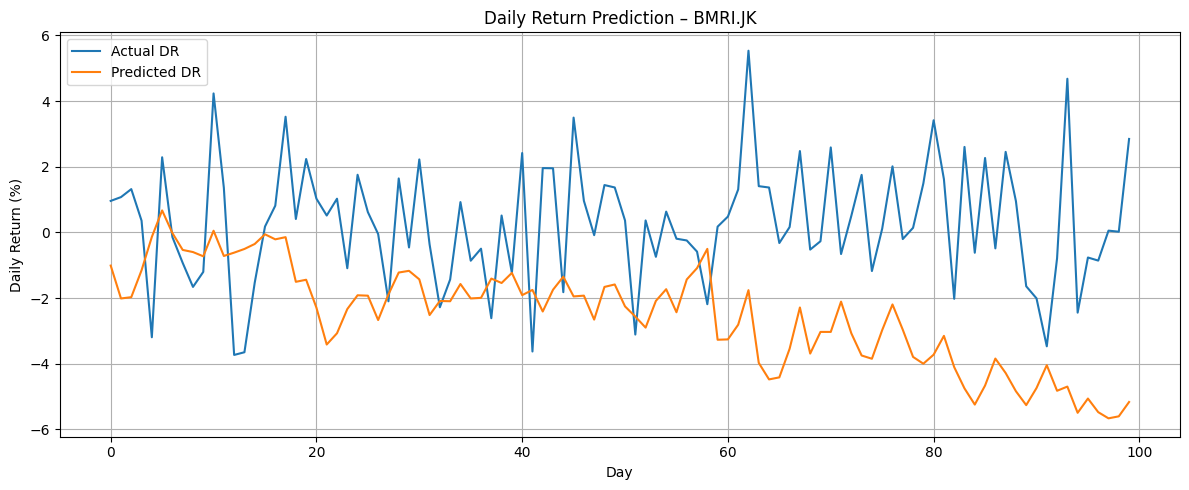

[*********************100%***********************]  1 of 1 completed


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.4643 - val_loss: 5.8195
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7429 - val_loss: 6.0612
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0252 - val_loss: 6.0563
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7683 - val_loss: 6.1419
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5652 - val_loss: 6.3856
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0646 - val_loss: 6.8816
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3436 - val_loss: 6.7127
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7816 - val_loss: 6.7241
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9696 - val_loss: 7.0923
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.8699 - val_loss: 7.7352
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8612 - val_loss: 7.3884
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8889 -

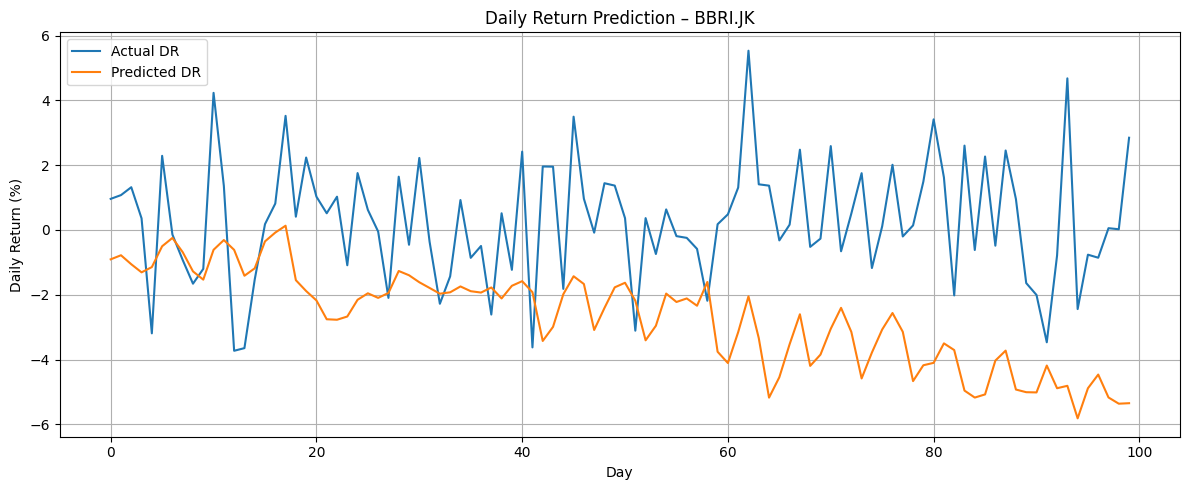

In [37]:
for i in ['BBCA.JK', 'BBNI.JK', 'BMRI.JK', 'BBRI.JK']:
    df = yf.download(i, start='2020-01-01', end='2025-07-31')
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    # Calculate Target – Daily Return (DR)
    df['DR'] = 100 * (df['Close'] - df['Open']) / df['Open']
    # AO
    ao_indicator = AwesomeOscillatorIndicator(high=df['High'].squeeze(),
                                              low=df['Low'].squeeze())
    ao_values = ao_indicator.awesome_oscillator()
    df['AO'] = ao_values
    # RSI
    close_series = df['Close'].squeeze()  
    rsi_indicator = RSIIndicator(close=close_series)
    df['RSI'] = rsi_indicator.rsi()
    
    # ATR
    atr_indicator = AverageTrueRange(high=df['High'].squeeze(),
                                     low=df['Low'].squeeze(),
                                     close=df['Close'].squeeze(),)

    df['ATR'] = atr_indicator.average_true_range()

    # ADX
    adx_indicator = ADXIndicator(high=df['High'].squeeze(),
                                 low=df['Low'].squeeze(),
                                 close=df['Close'].squeeze())

    df['ADX'] = adx_indicator.adx()

    # Aroon Up & Down
    aroon_indicator = AroonIndicator(close=df['Close'].squeeze())

    df['Aroon_Up'] = aroon_indicator.aroon_up()
    df['Aroon_Down'] = aroon_indicator.aroon_down()

    # Remove multi-index columns (if any)
    df.columns.name = None
    df.columns = df.columns.get_level_values(0)

    # Drop rows with NaN
    df = df.dropna().copy()

    df['Day'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter

    # One-hot encoding
    df = pd.get_dummies(df, columns=['Day', 'Month', 'Quarter'])

    # Prepare X and y
    X = df.drop(columns=['DR'])
    y = df['DR']

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=2)
    splits = list(tscv.split(X))

    # Take the last fold
    train_idx, test_idx = splits[-1]

    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Create Model
    model = Sequential()
    model.add(LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')


    model.summary()

    # Train Model
    history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
    )

    # Predict on test data
    y_pred = model.predict(X_test_seq).reshape(-1)

    # Calculate evaluation metrics
    rmse = mean_squared_error(y_test_seq, y_pred, squared=False)
    mae = mean_absolute_error(y_test_seq, y_pred)

    # Avoid division by zero in MAPE
    mask = y_test_seq != 0
    mape = mean_absolute_percentage_error(y_test_seq[mask], y_pred[mask])

    # Calculate Directional Accuracy (correct up/down direction)
    directional_acc = np.mean(np.sign(y_test_seq) == np.sign(y_pred)) * 100

    # Print evaluation results
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Directional Accuracy: {directional_acc:.2f}%")


    plt.figure(figsize=(12, 5))
    plt.plot(y_test_seq[:100], label='Actual DR')
    plt.plot(y_pred[:100], label='Predicted DR')
    plt.title(f'Daily Return Prediction – {i}')
    plt.xlabel('Day')
    plt.ylabel('Daily Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Key Observations
- The directional accuracy remains relatively consistent across all banks, hovering around 45%, indicating modest capability in predicting the direction of return.
- The MAPE ranges from ~10% to ~12%, suggesting that while the model captures general patterns, short-term return predictions are still noisy.
- RMSE and MAE values are higher in magnitude due to the volatility of daily return values.

### Visual Interpretation of Prediction Results
**Overall Pattern:**
- The projected Daily Return (orange line) is notably smoother and less volatile than the actual return (blue line), as is common in many LSTM models trained on financial data.
- This shows that the model captures the overall trend or direction but not the severe fluctuations (spikes and dips).

**Short-term Direction Prediction:**
- In some localized regions, the model reasonably follows an upward/downward movement.
- However, the anticipated direction does not always match the actual one, resulting in a ~45% directional accuracy.

**Prediction Bias:**
- The model's minimization of mean squared error causes it to underestimate extreme values. 
- This causes a "mean-reversion" effect, in which the forecasts follow a tight range relative to the actual data.

**Consistency Across Banks:**
- The prediction pattern is consistent across BBCA, BBNI, BMRI, and BBRI — indicating that the same model architecture responds similarly regardless of the ticker.
- This supports that the model is generalizing, but also confirms it is not fine-tuned to each bank's unique volatility pattern.

## IV. Conclusion, Business Impact & Recommendations

### Conclusion

This project implemented a predictive modeling approach using LSTM (Long Short-Term Memory) neural networks to forecast **Daily Return (DR)** of stocks, focusing on **NVIDIA** as the primary target, and applying the same methodology to the **Big 4 Indonesian banks**: BBCA, BBNI, BMRI, and BBRI.

Despite high volatility and noise in short-term returns, the model was able to:

- Capture general movement trends with reasonable directional accuracy (~45%)
- Achieve RMSE values between 4–6, showing moderate predictive precision
- Provide better-than-random insights into market behavior over short-term horizons

### Business Impact

If deployed strategically, the model can support financial decision-making by:

- Enhancing risk management: Predicting return direction helps in adjusting exposure or hedging
- Improving short-term tactical trading: Especially when used alongside technical indicators
- Supporting portfolio allocation: By flagging potentially high-volatility periods

Although the model isn't perfectly accurate (as expected in financial forecasting), directional signals can still be valuable when combined with human expertise or other models.

### Recommendations

1. **Feature Expansion**  
   Incorporate additional macroeconomic factors (e.g., interest rates, inflation, sectoral indices) to improve model context.

2. **Model Tuning & Ensemble**  
   Use ensemble methods or hybrid architectures (e.g., LSTM + XGBoost) to combine the strengths of multiple models.

3. **Asset-specific Tuning**  
   Fine-tune models separately for different stocks to capture asset-specific volatility and behavior.

4. **Real-time Retraining**  
   Integrate regular retraining pipelines (weekly/monthly) to adapt to market shifts.

5. **Alternative Targets**  
   Consider forecasting volatility, price direction, or risk-adjusted returns (e.g., Sharpe ratio) instead of raw daily return.

## V. Conclusion, Business Impact & Recommendations

### Conclusion

This project implemented a predictive modeling approach using LSTM (Long Short-Term Memory) neural networks to forecast **Daily Return (DR)** of stocks, focusing on **NVIDIA** as the primary target, and applying the same methodology to the **Big 4 Indonesian banks**: BBCA, BBNI, BMRI, and BBRI.

Despite high volatility and noise in short-term returns, the model was able to:

- Capture general movement trends with reasonable directional accuracy (~45%)
- Achieve RMSE values between 4–6, showing moderate predictive precision
- Provide better-than-random insights into market behavior over short-term horizons

### Business Impact

If deployed strategically, the model can support financial decision-making by:

- Enhancing risk management: Predicting return direction helps in adjusting exposure or hedging
- Improving short-term tactical trading: Especially when used alongside technical indicators
- Supporting portfolio allocation: By flagging potentially high-volatility periods

Although the model isn't perfectly accurate (as expected in financial forecasting), directional signals can still be valuable when combined with human expertise or other models.

### Recommendations

1. **Feature Expansion**  
   Incorporate additional macroeconomic factors (e.g., interest rates, inflation, sectoral indices) to improve model context.

2. **Model Tuning & Ensemble**  
   Use ensemble methods or hybrid architectures (e.g., LSTM + XGBoost) to combine the strengths of multiple models.

3. **Asset-specific Tuning**  
   Fine-tune models separately for different stocks to capture asset-specific volatility and behavior.

4. **Real-time Retraining**  
   Integrate regular retraining pipelines (weekly/monthly) to adapt to market shifts.

5. **Alternative Targets**  
   Consider forecasting volatility, price direction, or risk-adjusted returns (e.g., Sharpe ratio) instead of raw daily return.